# Detecting UPC Barcodes with YOLOv2

This notebook shows how to detect a specifc kind of object using [YOLOv2](https://pjreddie.com/darknet/yolov2/). In this case, barcodes. I´m going to use UPC barcode images as training dataset.  After finishing this notebook, I hope you will be able to train your own model, and detect objects that you are interested in.

YOLO stands for You Only Look Once and it is a high speed object detection algorithm. Acording to the article [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf), it is single convolutional network that simultaneously predicts multiple bounding boxes and class probabilities for those boxes as shown on the next figure. 

<img src="PrtSc/yolo.PNG" width="600">
YOLO (1) resizes the input image to 448 x 448, (2) runs a single convolutional network on the image, and (3) thresholds the resulting detections by the model’s confidence.

Basically, to predict an image, YOLO divides up the image into a $S \times S$ grid and for each grid cell predicts $B$ bounding boxes, the confidence for those boxes, and $C$ class probabilities. The figure below, from the article the same article, illutrates the main idea.

<img src="PrtSc/yolo-pipeline.png" width="500">

YOLO was originaly ran in a frameowork called [DarkNet](https://pjreddie.com/darknet/) that is an open source neural network framework written in C and CUDA. Howerver, C is not so user friendly. Thus, [Trieu](https://github.com/thtrieu) has created a TensorFlow version of it called [darkflow](https://github.com/thtrieu/darkflow).

I choose to use the [darkflow](https://github.com/thtrieu/darkflow) because it has been quite popular for Tensorflow support on Github open source hosting service. However, you can build the YOLO model on your own since the [official web-site](https://pjreddie.com/darknet/yolo/) provides the configuration and its pre-trained weights as external files.

In this notebook, I sumup all issues I had during the development as well as the applyed solutions.  

## Preparing the data

I used a dataset with 1054 images to train the model for detecting barcodes. I used [LabelImg](https://github.com/tzutalin/labelImg) tool to do the image annotation step. These annotations were saved as XML files in PASCAL VOC format.

<img src="PrtSc/LabelImg-2.PNG" width="800">

## Preparing Darkflow

First of all, I tried to run a demo in order to get sure that everything was working properly and I faced some issues. 

I downloaded both, configuration and weight files from [YOLOv2](https://pjreddie.com/darknet/yolov2/) website. I used the version highlighted in the image below. I also tried to use the Tiny YOLO but I got some erros. It seems that cfg file and weights are not compatible. In case the weight and cfg files cannot be found, I uploaded them [here](https://microsoft-my.sharepoint.com/:f:/p/gefausti/ErfTMlbNS8RKuNz_FQQsjjUBYWnAH6todEbyhcAT5TE_KA?e=UMhqkZ).

<img src="PrtSc/cfg_file_and_weight.png">

The issues that I had:

1. To solve the error `AssertionError: expect 63184556 bytes, found 63184560` we have to change `self.offset = 16` to `self.offset = 20` in utils/loader.py. [[1]](https://github.com/thtrieu/darkflow/issues/421)

2. I had also to change the line `annotations = glob.glob(str(annotations)+'*.xml')` to `annotations = glob.glob('*.xml')` in the darkflow\utils\pascal_voc_clean_xml.py. [[2]](https://github.com/thtrieu/darkflow/issues/439)

<table><tr>
    <td> <img src="PrtSc/modify_the_line.PNG" width='400'/> </td>
    <td> <img src="PrtSc/annotions.PNG" width='423'/> </td>
</tr></table>

3. `AssertionError: labels.txt and yolov2-voc.cfg indicate inconsistent class numbers`. According to [[3]](https://github.com/thtrieu/darkflow/issues/295), when darkflow sees one of the default .cfg names it will load the labels from it's own array (or external file in the case of the COCO dataset) - i.e. when it sees a recognized .cfg it will ignore what is set in labels.txt. You can see what the recognized .cfg names are [here](). So, I just renamed the file `yolov2-voc.cfg` to `yolo-voc.cfg`.

After this three little changes I was able to run the demo. To run a demo, just run the code:   
` python flow --model cfg/YOUR_MODEL.cfg --load bin/YOUR_WEIGHTS.weights --demo INPUT-VIDEO.mp4 --gpu 1.0 --saveVideo`   
For this demo I didn´t use GPU. For more details, check this [site](https://github.com/thtrieu/darkflow#cameravideo-file-demo)

<img src="PrtSc/demo_video.PNG">

You can see the output video [here](https://microsoft-my.sharepoint.com/:v:/p/gefausti/EZLl1u9fnbJErkBMhjSKsLEBe1DsRWWYjOGT8UPk8IJodQ?e=fVwIQH).  
I also tested in other video. You can see it [here](https://microsoft-my.sharepoint.com/:v:/p/gefausti/EYegbaL2DqRGpdCeB2BZ1w8BrNekiEGx1GjNmZGCI1dXeA?e=GAyQ8K)

## Training the model

In order to traing our own model, we have to just follow the steps described in the section ["Training on your own dataset"](https://github.com/thtrieu/darkflow#training-on-your-own-dataset).  
Basicaly we have to:  

 **1. Modify a cfg file so that it has a proper final layer and then we can train on our dataset**

* Create a copy of the original configuration file and rename it according to your preference. Here, I copy the file `yolo-voc.cfg` and renamed it to `yolo-voc-1c.cfg`, because I have only one class.  
<font color='red'>*Note: It is crucial that you leave the original file unchanged!!!*</font>  


* In the file `yolo-voc-1c.cfg` change classes in the last layer to the number of classes you are going to train for. In my case, classes are set to 1.  


* Also, in the same file, change filters in the [convolutional] layer (the second to last layer) to $num * (classes + 5)$. In my case, num is 5 and classes are 1 so 5 * (1 + 5) = 30 therefore filters are set to 30.

<img src="PrtSc/cfg2.PNG">

**2. Modify the labels file**
* Change `labels.txt` to include the label(s) you want to train on. Note that, the number of labels should be the same as the number of classes you set in `yolo-voc-1c.cfg` file. Thus, here `labels.txt` will contain just 1 label.
<img src="PrtSc/labels.PNG">

**3. How to call flow so that way we can train on our dataset and generate new wights for our model**

You can train your model inside a jupyter notebook but I did it in Anaconda cmd. I used a [Deep Learning VM on Azure](https://docs.microsoft.com/en-us/azure/machine-learning/data-science-virtual-machine/deep-learning-dsvm-overview). More datails about how train the model can be found [here](https://github.com/thtrieu/darkflow#training-on-your-own-dataset).

In a general way, the command to train is:  
`flow --model cfg/YOUR_CFG_FILE.cfg --load bin/PRETRAINED_WEIGHTS.weights --train --annotation train/Annotations --dataset train/Images`

In this command, we call flow, then we load our new model, that is `yolo-voc-1c.cfg`, after that we load the weights (we´ll start with the pretrained weights), then call `--train` and `--annotation` to specify where the annotation files are and `--dataset` to specify where the corresponding images are. You can also set the GPU and the number of ephocs you want.

<img src="PrtSc/training1.PNG">

While it is training, there is a folder called ckp. During the training, all your files will be load in this folder. For each checkpoint, you will see a data file (that basically is the wwights), an index file, a meta file and a profile file. 

<img src="PrtSc/generated_files.PNG" width='600'>

## Using the trained model

Now we are see how to load those weights and "test" our model.  

**Importing Dependencies**

In [1]:
%matplotlib inline
import utils

import cv2
import numpy as np

from darkflow.net.build import TFNet
# Note: In order the import above works, I had to reinstall darkflow globally (pip install .).

**Defining model options**

Basically, in the options dictionary, we specify the model we are going to be loading (here I´m going to use my trained model, that is `yolo-voc-1c.cfg`). Then, in order to load the weights, we are goint to use the last step that our training went to (instead of specify the file, you only need to specify the estep number, in my case it is 29125). We also set the threshold and GPU as well. More details about how to use darkflow from another python application can be found [here](https://github.com/llSourcell/YOLO_Object_Detection#using-darkflow-from-another-python-application).

In [2]:
options = {
    'model': 'cfg/yolo-voc-1c.cfg',
    'load': 29125,
    'threshold': 0.1,
    'gpu': 1.0
}

**Running the model**

In [3]:
tfnet = TFNet(options)

Parsing cfg/yolo-voc-1c.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 104, 104, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 52, 52, 128)
 Init  |

**Using the trained model to predict images**

In [4]:
from os import listdir

image_dir = 'C:/Geisa/YOLO/Dataset/myBarcodes'
predicted_images = []

for file in listdir(image_dir):
    image_path = image_dir + '/' + file
    image = utils.read_image( image_path )
    
    # use YOLO to predict the image
    result = tfnet.return_predict(image)
    
    if result:
        predicted_images.append( ( image, result ) )
    else:
        print("No result for: " ,image_path)

print( len(predicted_images) )

No result for:  C:/Geisa/YOLO/Dataset/myBarcodes/20181004_081005.jpg
42


**Visualizing results**  
Note: Only bounding boxes with confidence greater than 0.4 are drawn.  

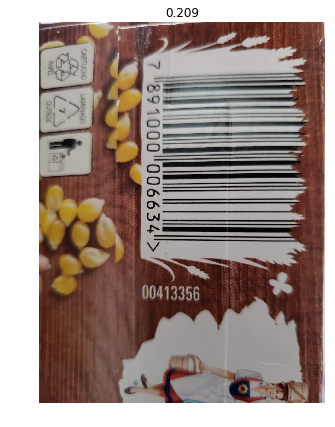

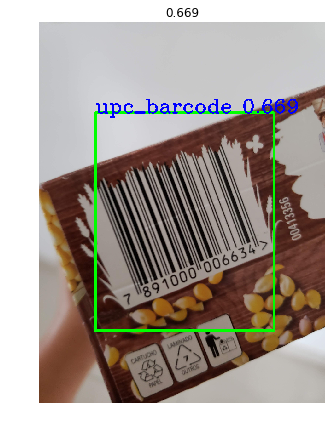

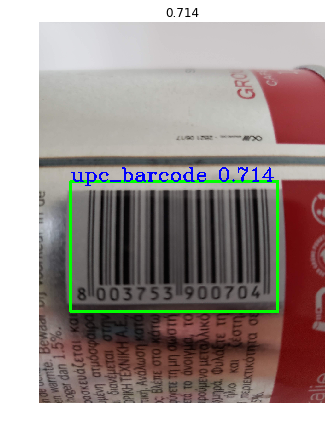

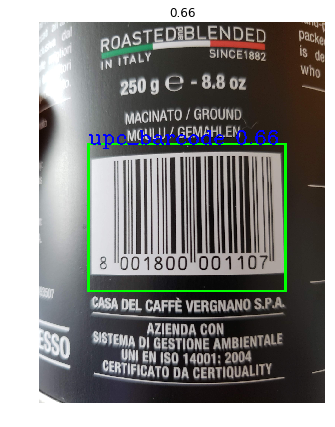

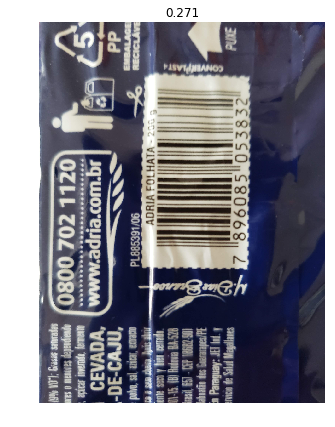

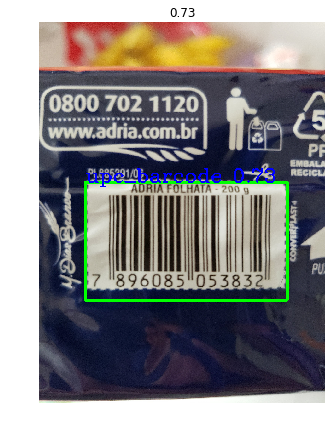

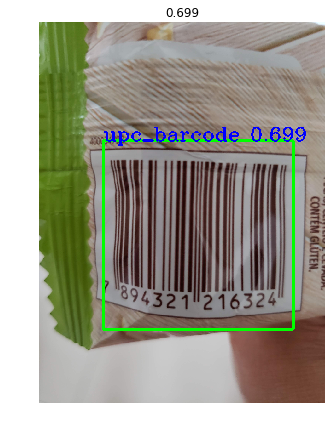

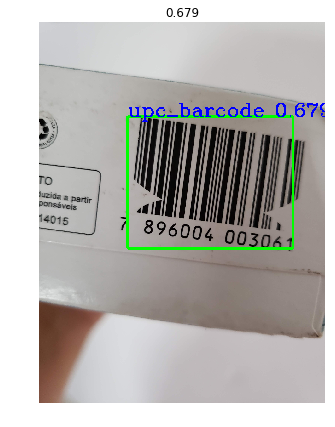

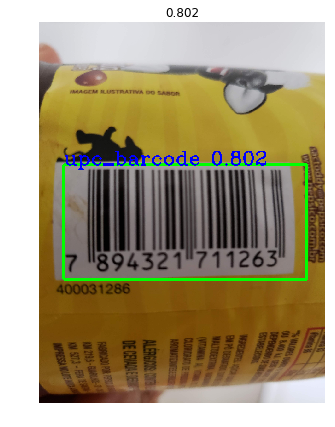

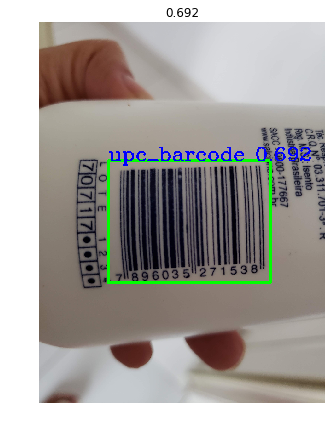

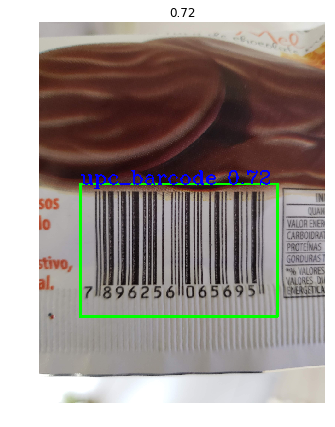

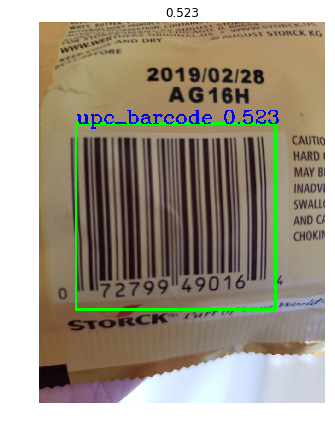

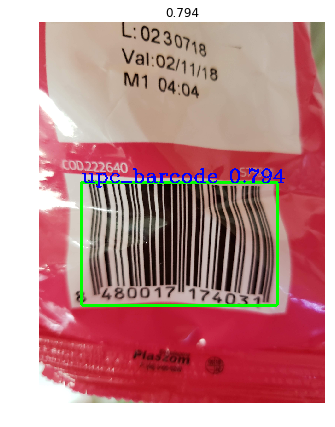

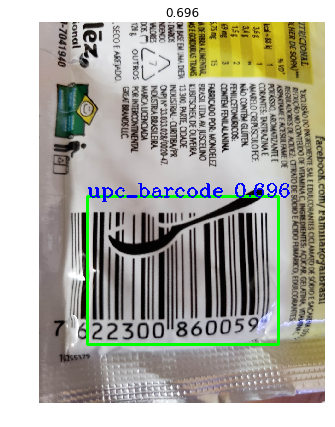

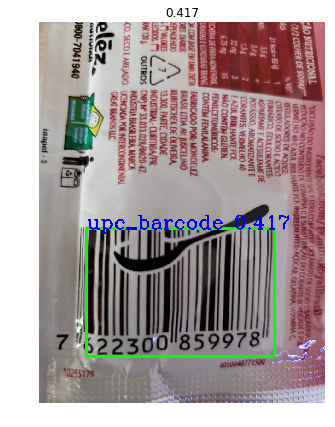

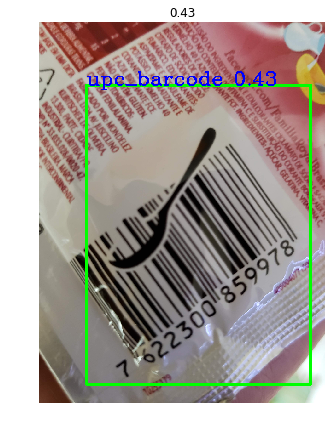

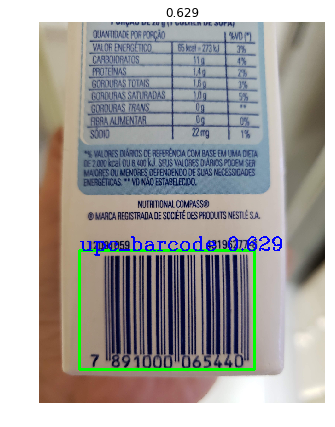

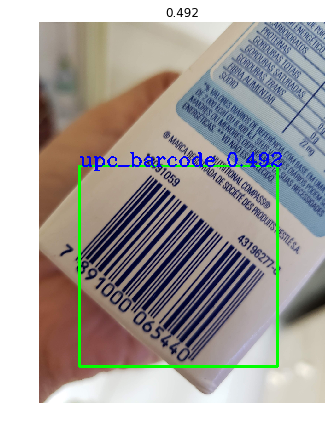

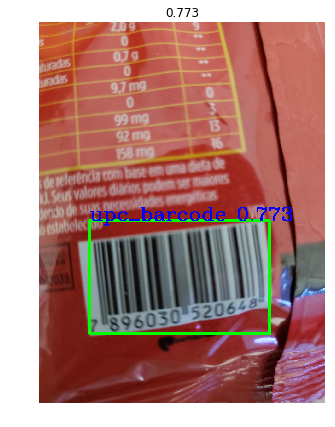

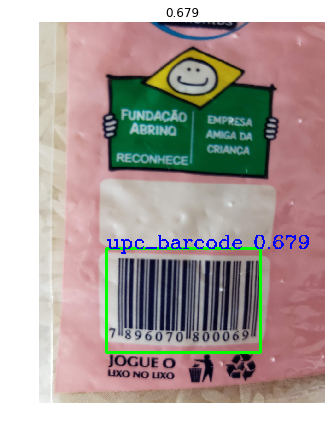

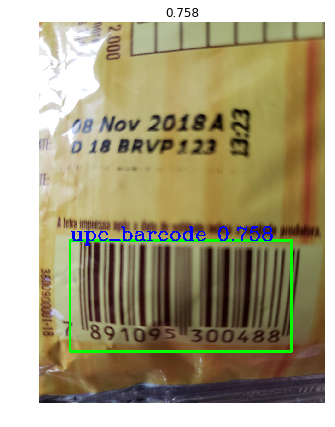

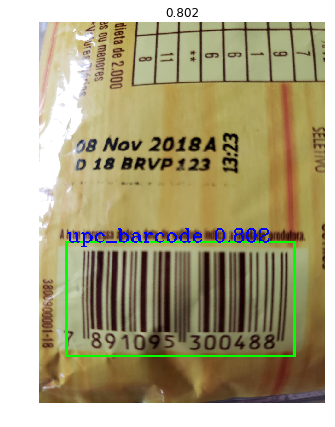

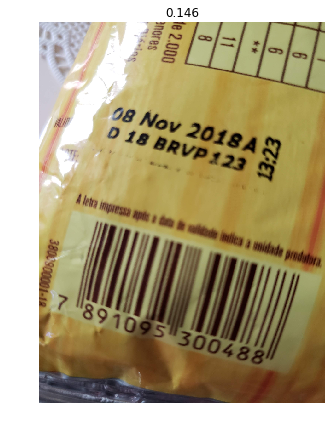

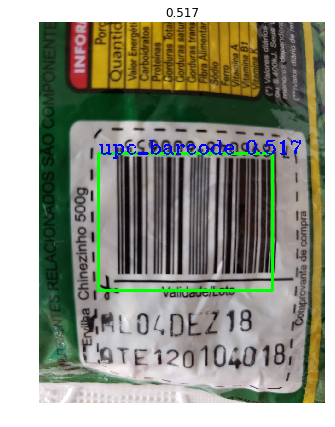

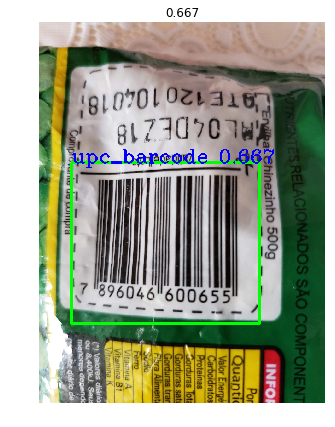

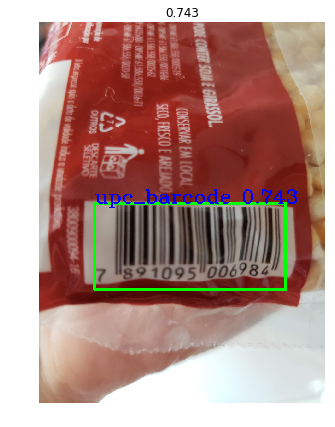

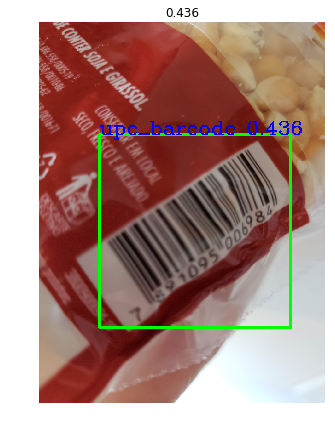

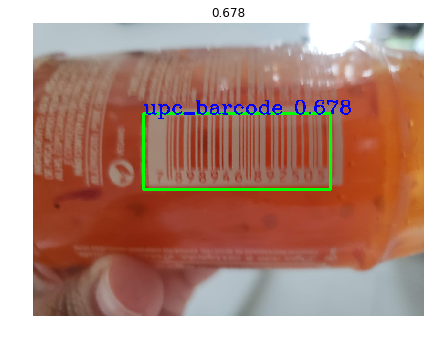

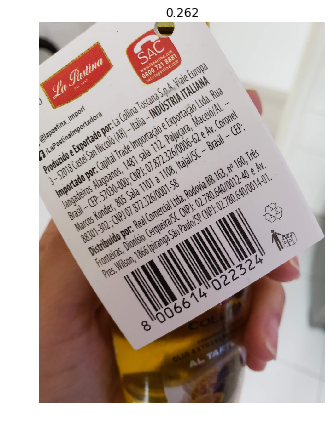

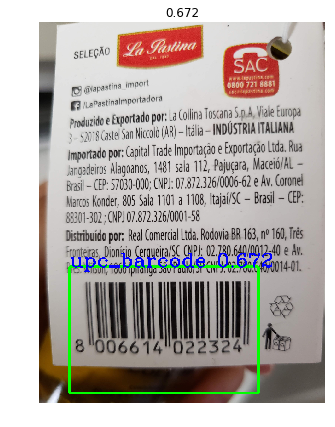

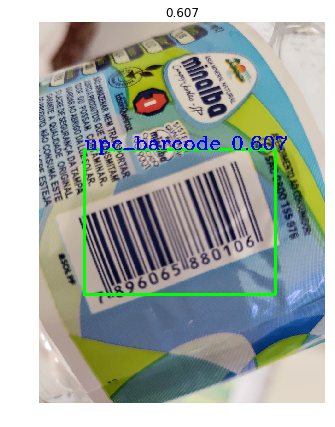

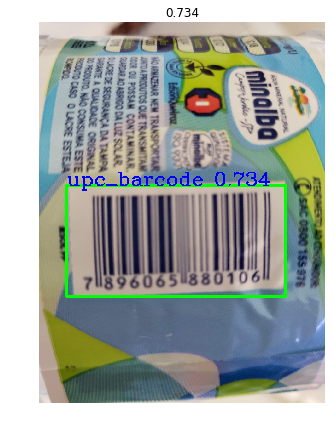

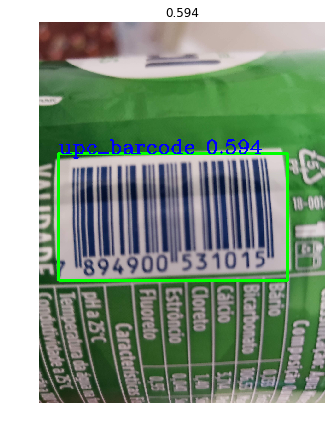

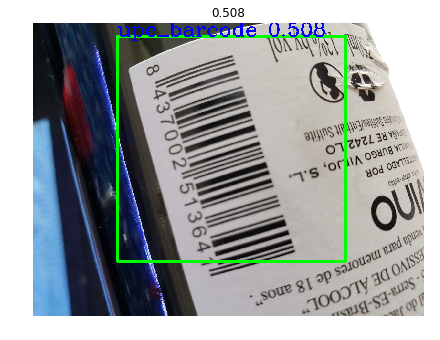

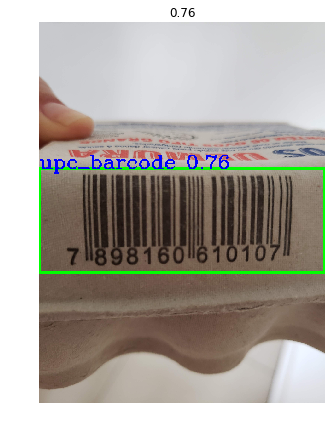

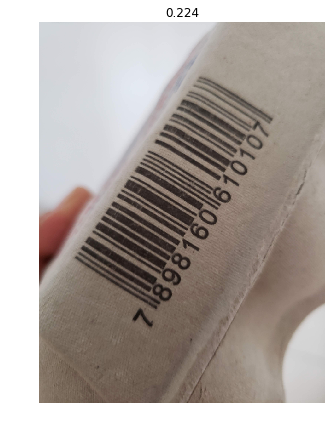

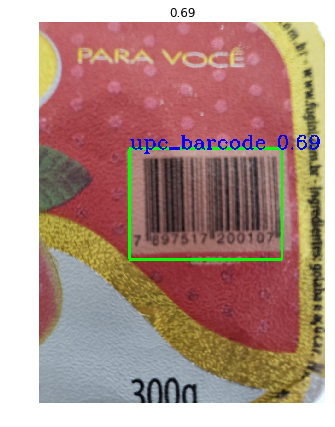

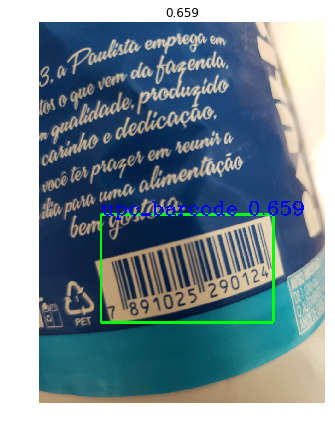

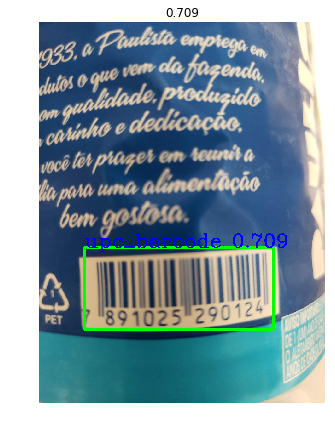

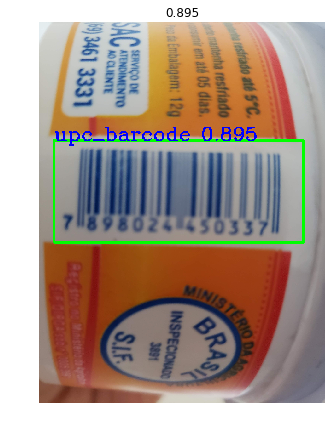

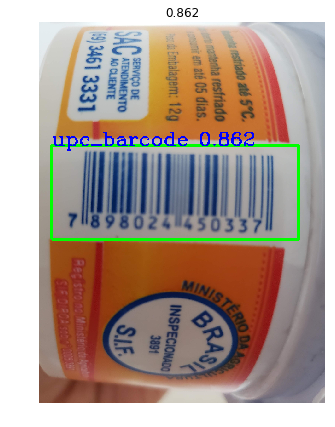

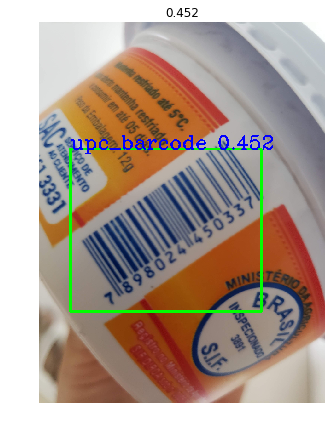

In [5]:
utils.rendering_images(predicted_images)

For a dataset of 42 images, only 5 images had a prediction with confidence less than 0.4. Thus, we have a precision of 0.88.

## Predicting on a video

In [1]:
input_video = 'C:/Geisa/YOLO/upc_video.mp4'
output_video = 'C:/Geisa/YOLO/upc_video_predicted.mp4'

In [ ]:
cap = cv2.VideoCapture(input_video)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(output_video, fourcc, 20.0, (int(width), int(height)))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)      
        results = tfnet.return_predict(frame)
        
        new_frame, _ = utils.drawing_boundingboxes(frame, results)

        # Display the resulting frame
        out.write(new_frame)
        cv2.imshow('frame', new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

You can see the output video [here](https://microsoft-my.sharepoint.com/:v:/p/gefausti/ES19EKDQWFJCifRwQNZz_W8BumLkbAakgRTfE1MAGv4XWA?e=tyDF7E).

## References

* [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/)
* [YOLO Object Detection (TensorFlow tutorial)](https://www.youtube.com/watch?v=4eIBisqx9_g)
* [Image Detection with YOLO-v2](https://www.youtube.com/watch?v=PyjBd7IDYZs&index=1&list=PLX-LrBk6h3wSGvuTnxB2Kj358XfctL4BM)
* [Soccer-Ball-Detection-YOLOv2](https://github.com/deep-diver/Soccer-Ball-Detection-YOLOv2/blob/master/YOLOv2-Train.ipynb)